In [ ]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

# Uso de GPU (Local)
import torch                                                                   # Librería principal de PyTorch
from torch import cuda                                                         # Librería para trabajar con GPU
USE_GPU = torch.cuda.is_available()                                            # Activar uso de GPU
device = torch.device('cuda' if USE_GPU else 'cpu')                            # Dispositivo (GPU o CPU)

# Importación librerías
import os                                                                      # Librería para interactuar con el sistema operativo
import pandas as pd                                                            # Librería para manipulación de datos
import matplotlib.pyplot as plt                                                # Librería para visualización de datos
import seaborn as sns                                                          # Librería para visualización de datos
import numpy as np                                                             # Librería para manipulación de arrays y matrices

from sklearn.model_selection import train_test_split                           # División de datos en entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer                    # Vectorización de texto
from sklearn.preprocessing import MultiLabelBinarizer                          # Binarización de etiquetas múltiples
from sklearn.multiclass import OneVsRestClassifier                             # Vectorización de etiquetas múltiples
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier     # Modelos de bosque aleatorio
from sklearn.linear_model import LogisticRegression                            # Regresión logística
from sklearn.metrics import r2_score, roc_auc_score                            # Métricas de evaluación

import torch.nn as nn                                                          # Redes neuronales
import torch.optim as optim                                                    # Optimizadores de PyTorch
from torch.utils.data import DataLoader, TensorDataset                         # Cargador de datos de PyTorch

# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

# Verifica que son listas
print(type(dataTraining['genres'].iloc[0]))  # Debe decir: <class 'str'> o <class 'list'>

# Si los géneros están como strings, convertirlos a listas
if isinstance(dataTraining['genres'].iloc[0], str):
    dataTraining['genres'] = dataTraining['genres'].apply(eval)

# Binarizar
mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(dataTraining['genres'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores y mover al dispositivo adecuado
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Paso 2: Dataset y Dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Paso 3: Definición de modelo
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = SimpleNN(input_size=X.shape[1], num_classes=y.shape[1]).to(device)

# Paso 4: Entrenamiento
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_roc = 0
for epoch in range(22):
    model.train()
    for xb, yb in dataloader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    # Validación
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        roc = roc_auc_score(y_val_tensor.cpu().numpy(), val_preds.cpu().numpy(), average='macro')
        print(f"Epoch {epoch+1}, ROC-AUC: {roc:.4f}")
        
        # Guardar el mejor modelo
        if roc > best_roc:
            best_roc = roc
            torch.save(model.state_dict(), 'best_model.pth')

# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
with torch.no_grad():
    y_pred_test_nn = model(X_test_tensor).cpu().numpy()

<class 'str'>


KeyError: 'plot_clean_bert'

In [4]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd

# Initialize tqdm for pandas
tqdm.pandas()

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)  # Move model to GPU

def get_bert_embeddings(text):
    # Tokenize and move inputs to the same device as model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Move outputs back to CPU for numpy conversion
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Apply to your text column with progress bar
dataTraining['plot_clean_bert'] = dataTraining['plot'].progress_apply(get_bert_embeddings)

Using device: cuda


100%|██████████| 7895/7895 [00:40<00:00, 195.04it/s]


In [1]:
# 1. First, load and prepare your data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load data
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

# 2. Process genres
if isinstance(dataTraining['genres'].iloc[0], str):
    dataTraining['genres'] = dataTraining['genres'].apply(eval)

mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(dataTraining['genres'])

# 3. Generate BERT embeddings (this is the part you were missing)
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Generate embeddings for training data
dataTraining['plot_clean_bert'] = dataTraining['plot'].progress_apply(get_bert_embeddings)

# Generate embeddings for test data (important!)
dataTesting['plot_clean_bert'] = dataTesting['plot'].progress_apply(get_bert_embeddings)

# 4. Now proceed with your model
X = np.vstack(dataTraining['plot_clean_bert'].values)
y = y_genres

# Rest of your model code...
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Continue with your neural network implementation...

C:\Users\didan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3383/3383 [00:16<00:00, 202.41it/s]


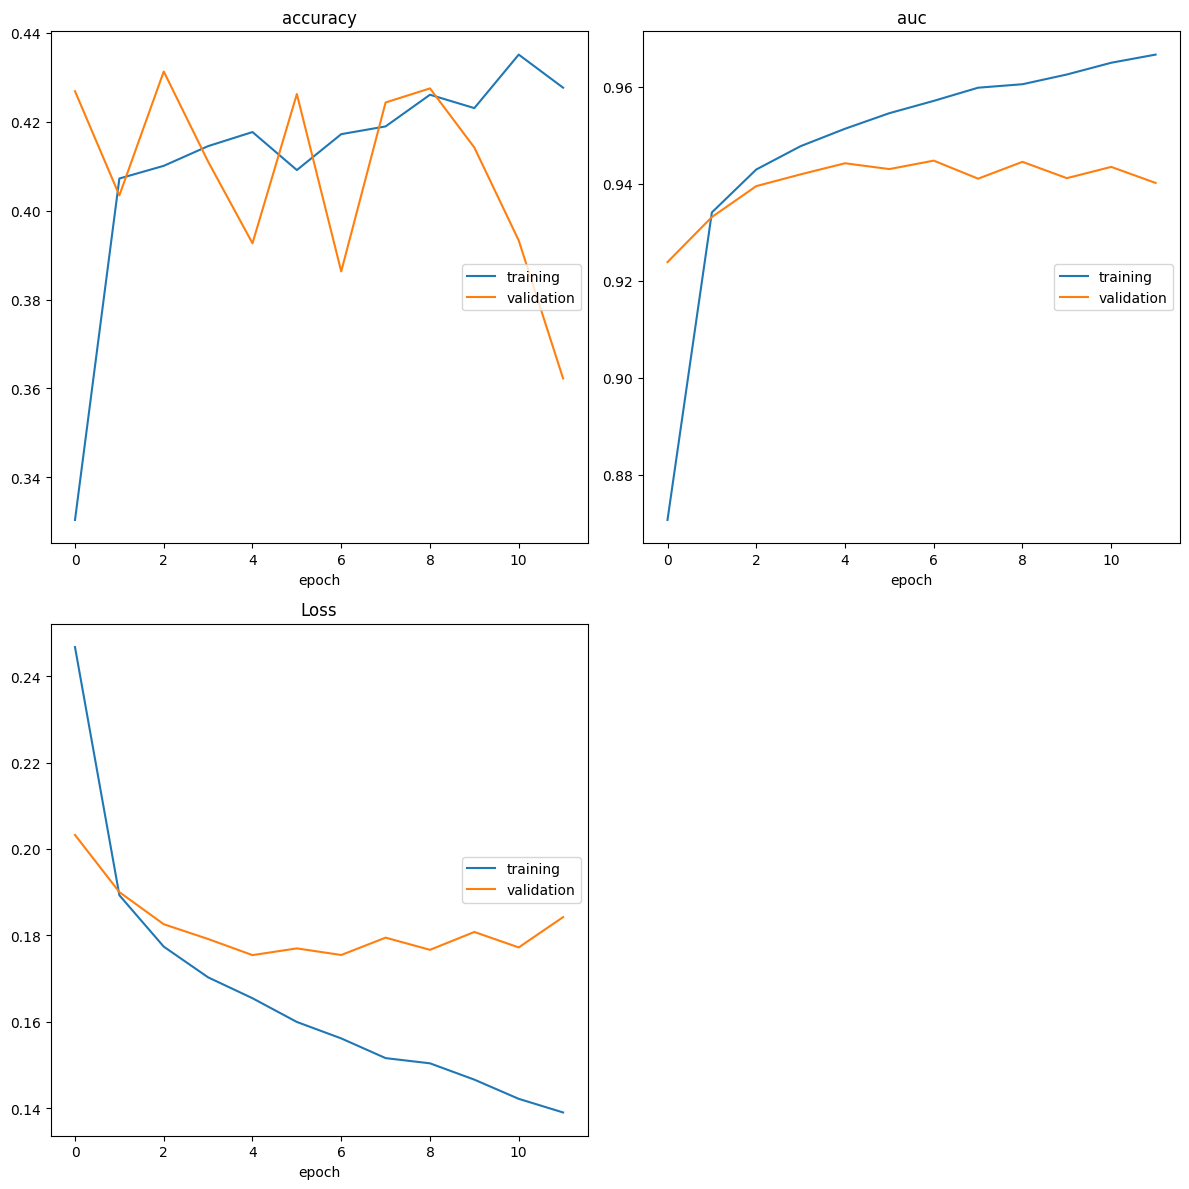

accuracy
	training         	 (min:    0.330, max:    0.435, cur:    0.428)
	validation       	 (min:    0.362, max:    0.431, cur:    0.362)
auc
	training         	 (min:    0.871, max:    0.967, cur:    0.967)
	validation       	 (min:    0.924, max:    0.945, cur:    0.940)
Loss
	training         	 (min:    0.139, max:    0.247, cur:    0.139)
	validation       	 (min:    0.175, max:    0.203, cur:    0.184)
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4239 - auc: 0.9668 - loss: 0.1387 - val_accuracy: 0.3623 - val_auc: 0.9402 - val_loss: 0.1842

Evaluación en conjunto de validación:
Loss: 0.1754, Accuracy: 0.3927, AUC: 0.9443
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


Modelo guardado como bert_classifier_model.h5


In [2]:
# Definición de dimensiones de salida (variables de interés)
output_var = y_train.shape[1]
print(output_var, 'output variables')

# Definición de dimensiones de entrada (variables predictoras)
dims = X_train.shape[1]
print(dims, 'input variables')

# Importación librerías
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf

# Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible y configurada")
else:
    print("No se encontró GPU, usando CPU")

# Definición de función que crea la red neuronal
def nn_model_params(optimizer='adam',
                   neurons=128,
                   batch_size=32,
                   epochs=50,
                   activation='relu',
                   patience=5,
                   loss='binary_crossentropy'):
    
    K.clear_session()

    model = Sequential()
    
    # Capa de entrada y primera capa oculta
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    # Segunda capa oculta
    model.add(Dense(neurons, activation=activation))
    # Capa de salida (usamos sigmoid para clasificación multi-etiqueta)
    model.add(Dense(output_var, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', metrics.AUC(name='auc')])
    
    # Early Stopping
    early_stopping = EarlyStopping(monitor="val_loss",
                                 patience=patience,
                                 restore_best_weights=True)

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[early_stopping, PlotLossesKeras()],
                       verbose=1)
    
    return model, history

# Parámetros del modelo
params = {
    'optimizer': Adam(learning_rate=0.001),
    'neurons': 256,  # Aumentado para manejar embeddings BERT
    'batch_size': 32,
    'epochs': 50,
    'activation': 'relu',
    'patience': 7,  # Paciencia mayor para embeddings profundos
    'loss': 'binary_crossentropy'
}

# Entrenamiento del modelo
model, history = nn_model_params(**params)

# Evaluación del modelo
print("\nEvaluación en conjunto de validación:")
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

# Predicción en el conjunto de prueba
y_pred_test = model.predict(np.vstack(dataTesting['plot_clean_bert'].values))

# Guardar el modelo
model.save('bert_classifier_model.h5')
print("Modelo guardado como bert_classifier_model.h5")

## Aplicación del modelo a datos de test

In [3]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [4]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_NN_RSearch.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.007162,0.018530,0.001482,0.011009,0.024686,0.069040,0.000222,0.883249,0.008606,0.080623,...,0.007409,0.339396,0.000112,0.617556,0.005179,0.003402,0.000076,0.328920,0.001952,0.007047
4,0.297842,0.012429,0.000070,0.144250,0.078653,0.652690,0.014036,0.924705,0.001217,0.000296,...,0.002288,0.020803,0.000994,0.120313,0.000114,0.000205,0.043526,0.516024,0.017563,0.000444
5,0.056572,0.005996,0.000277,0.053408,0.043522,0.785817,0.004032,0.871750,0.002453,0.010924,...,0.002721,0.539375,0.000766,0.101778,0.003832,0.000677,0.002445,0.707711,0.001651,0.002430
6,0.431542,0.192758,0.001931,0.015500,0.147297,0.063833,0.000390,0.718527,0.003746,0.007126,...,0.011494,0.030786,0.000118,0.289307,0.089130,0.001370,0.005050,0.379881,0.249678,0.013699
7,0.008529,0.008654,0.002866,0.005103,0.110648,0.032922,0.003012,0.292508,0.013231,0.117997,...,0.005678,0.354613,0.000566,0.079727,0.518581,0.006231,0.000073,0.407354,0.000180,0.000557
